# **Homework Assignment 2**

# **Rob Boswell**

---
---



### **Question 1:** Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.

---

### **Answer:**

The dataset comprises X-ray images in three classes - the first class includes individuals who had viral pneumonia, the second includes those who do not have any infection that would be visible from X-rays, i.e. their X-rays are "normal." The third class includes those who had COVID-19 at the time of the X-ray.

The "viral pneumonia" class has 1,345 images/observations. The "normal" class has 1,341 images/observations. The "covid" class has 1,201 images/observations.

Building a predictive model using X-ray image data would be potentially very useful. First, if patients are able to receive X-ray results back before they can receive COVID-19 test results back, or if COVID-19 tests are not available (e.g., in developing countries where X-ray machines are readily available), patients would be able to know likely very quickly (perhaps even within minutes) whether there was a very high probability that they had COVID-19. This is important because even COVID-19 tests that are given as swabs through the nose are not 100% accurate.

Patients (and their loved ones and those who live with them or near them) would be benefited because those diagnosed with COVID-19 by X-ray would know to immediately quarantine. If they did so immediately, this would likely reduce the spread of COVID-19 from infected patients since those who take a regular COVID-19 test often do not receive their test results back the same day, and likely in the meantime would not quarantine.

As a result, in reality, not only would the person receiving the X-ray and their family and loved ones and those who they come in contact with
benefit from a highly accurate X-ray method of prediction, but truly society at large since there would likely not be as much spread of the virus if X-ray results could be disseminated within minutes of having them taken. 

---
---



### **Dataset Reference:**
M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145

---
---

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import os



In [20]:
    !gdown --id 1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl
    !unzip COVID-19_Radiography_Database.zip

Downloading...
From: https://drive.google.com/uc?id=1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl
To: /content/my-drive/My Drive/Colab Notebooks/Advanced_Machine_Learning_2nd_Semester/Assignment_2/COVID-19_Radiography_Database.zip
1.22GB [00:08, 147MB/s]
Archive:  COVID-19_Radiography_Database.zip
  inflating: COVID-19 Radiography Database/COVID.metadata.xlsx  
   creating: COVID-19 Radiography Database/COVID/
  inflating: COVID-19 Radiography Database/COVID/COVID (1).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (10).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (100).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1000).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1001).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1002).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1003).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1004).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1005

In [5]:
from google.colab import drive
drive.mount('/content/my-drive/') 


Drive already mounted at /content/my-drive/; to attempt to forcibly remount, call drive.mount("/content/my-drive/", force_remount=True).


In [24]:
!pwd
import os
os.chdir('/content/my-drive/My Drive/Colab Notebooks/Advanced_Machine_Learning_2nd_Semester/Assignment_2/')
!pwd

/content/my-drive/My Drive/Colab Notebooks/Advanced_Machine_Learning_2nd_Semester/Assignment_2
/content/my-drive/My Drive/Colab Notebooks/Advanced_Machine_Learning_2nd_Semester/Assignment_2


In [25]:
# Colab Setup: 
# note that tabular preprocessors require scikit-learn>=0.24.0
# Newest Tensorflow 2 has some bugs for onnx conversion
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [26]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

In [27]:

base_path = 'HW2_Photos'
categories = ['Viral Pneumonia', 'NORMAL', 'COVID']


fnames = []
for category in categories:
    COVID_folder = os.path.join(base_path, category)
    file_names = os.listdir(COVID_folder)
    full_path = [os.path.join(COVID_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) 

number of images for each category: [1345, 1341, 1200]
[['HW2_Photos/Viral Pneumonia/Viral Pneumonia (1).png', 'HW2_Photos/Viral Pneumonia/Viral Pneumonia (10).png', 'HW2_Photos/Viral Pneumonia/Viral Pneumonia (100).png', 'HW2_Photos/Viral Pneumonia/Viral Pneumonia (1000).png', 'HW2_Photos/Viral Pneumonia/Viral Pneumonia (1001).png', 'HW2_Photos/Viral Pneumonia/Viral Pneumonia (1002).png', 'HW2_Photos/Viral Pneumonia/Viral Pneumonia (1003).png', 'HW2_Photos/Viral Pneumonia/Viral Pneumonia (1004).png', 'HW2_Photos/Viral Pneumonia/Viral Pneumonia (1005).png', 'HW2_Photos/Viral Pneumonia/Viral Pneumonia (1006).png', 'HW2_Photos/Viral Pneumonia/Viral Pneumonia (1007).png', 'HW2_Photos/Viral Pneumonia/Viral Pneumonia (1008).png', 'HW2_Photos/Viral Pneumonia/Viral Pneumonia (1009).png', 'HW2_Photos/Viral Pneumonia/Viral Pneumonia (101).png', 'HW2_Photos/Viral Pneumonia/Viral Pneumonia (1010).png', 'HW2_Photos/Viral Pneumonia/Viral Pneumonia (1011).png', 'HW2_Photos/Viral Pneumonia/Viral Pneu

In [28]:
def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        
        img = cv2.resize(img, (192,192)) 
        img = img / 255.0 # Min-max transform.

        X = np.array(img)
        
        X = np.array(X, dtype=np.float32) 
        return X

preprocessor('HW2_Photos/Viral Pneumonia/Viral Pneumonia (3).png').shape

(192, 192, 3)

In [29]:
HW2_filepaths=fnames[0]+fnames[1]+fnames[2]

preprocessed_image_data=list(map(preprocessor,HW2_filepaths ))

X= np.array(preprocessed_image_data) 

In [30]:
X.shape

(3886, 192, 192, 3)

In [31]:
print(len(preprocessed_image_data) ) 
print(preprocessed_image_data[0].shape ) 
print(preprocessed_image_data[0].min() ) 
print(preprocessed_image_data[0].max() ) 
X.shape

3886
(192, 192, 3)
0.0
1.0


(3886, 192, 192, 3)

In [32]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
pneumonia=list(repeat("Viral Pneumonia", 1345))
normal=list(repeat("NORMAL", 1341))
covid19=list(repeat("COVID", 1200))

#combine into single list of y labels
y_labels = pneumonia+normal+covid19

#check length, same as X above
print(len(y_labels)) 

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1345, 1341, 1200]
3886


,COVID,NORMAL,Viral Pneumonia
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
3881,1,0,0
3882,1,0,0
3883,1,0,0
3884,1,0,0


In [33]:
X[0].shape

(192, 192, 3)

### **Question 2:**	Visualize images that demonstrate when x-rays demonstrate Covid Postivity and when they do not (You can present visuals of each category in the data if you would like to).

---

### **Answer:** 

As seen below, chest X-rays of individuals with COVID-19 tend to have much much more inflamation than chest X-rays of individuals who do not have COVID-19.

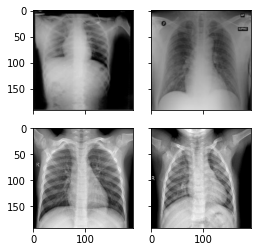

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor('HW2_Photos/COVID/COVID (235).png')
im2 =preprocessor('HW2_Photos/COVID/COVID (199).png')
im3 =preprocessor('HW2_Photos/NORMAL/NORMAL (1005).png')
im4 =preprocessor('HW2_Photos/NORMAL/NORMAL (1073).png')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(2, 2),  
                 axes_pad=0.25,  
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    
    ax.imshow(im)
plt.show()

---
---


In [35]:
# Train test split resized images
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)


y_train 

,COVID,NORMAL,Viral Pneumonia
715,0,0,1
1410,0,1,0
3874,1,0,0
2804,1,0,0
674,0,0,1
...,...,...,...
2808,1,0,0
999,0,0,1
3129,1,0,0
2933,1,0,0


In [36]:
X_train.shape

(3108, 192, 192, 3)

---

---

#**Model 1:**

---


In [47]:
from keras.callbacks import ModelCheckpoint

with tf.device('/device:GPU:0'): 

  model = tf.keras.Sequential([
       
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.15) 
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True)
  model.compile(
    optimizer="adam", 
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  
  model.fit(X_train, y_train, 
                    epochs = 25, verbose=1,validation_split=0.20, callbacks=[red_lr, mc]) 

Train on 2486 samples, validate on 622 samples
Epoch 1/25
2464/2486 [============================>.] - ETA: 0s - loss: 0.5836 - acc: 0.7163
Epoch 00001: val_acc improved from -inf to 0.88585, saving model to best_model.h5
2486/2486 [==============================] - 14s 6ms/sample - loss: 0.5823 - acc: 0.7172 - val_loss: 0.3215 - val_acc: 0.8859
Epoch 2/25
2464/2486 [============================>.] - ETA: 0s - loss: 0.2874 - acc: 0.8949
Epoch 00002: val_acc did not improve from 0.88585
2486/2486 [==============================] - 11s 4ms/sample - loss: 0.2876 - acc: 0.8946 - val_loss: 0.3679 - val_acc: 0.8585
Epoch 3/25
2464/2486 [============================>.] - ETA: 0s - loss: 0.2142 - acc: 0.9286
Epoch 00003: val_acc improved from 0.88585 to 0.90514, saving model to best_model.h5
2486/2486 [==============================] - 12s 5ms/sample - loss: 0.2131 - acc: 0.9288 - val_loss: 0.2772 - val_acc: 0.9051
Epoch 4/25
2464/2486 [============================>.] - ETA: 0s - loss: 0.1872 

In [48]:
import tensorflow.keras.backend as K

print(model.get_config()) 
print(K.eval(model.optimizer.get_config())) 
print(len(model.history.epoch)) 

{'name': 'sequential_6', 'layers': [{'class_name': 'Conv2D', 'config': {'name': 'conv2d_60', 'trainable': True, 'batch_input_shape': (None, 192, 192, 3), 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d_61', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'se

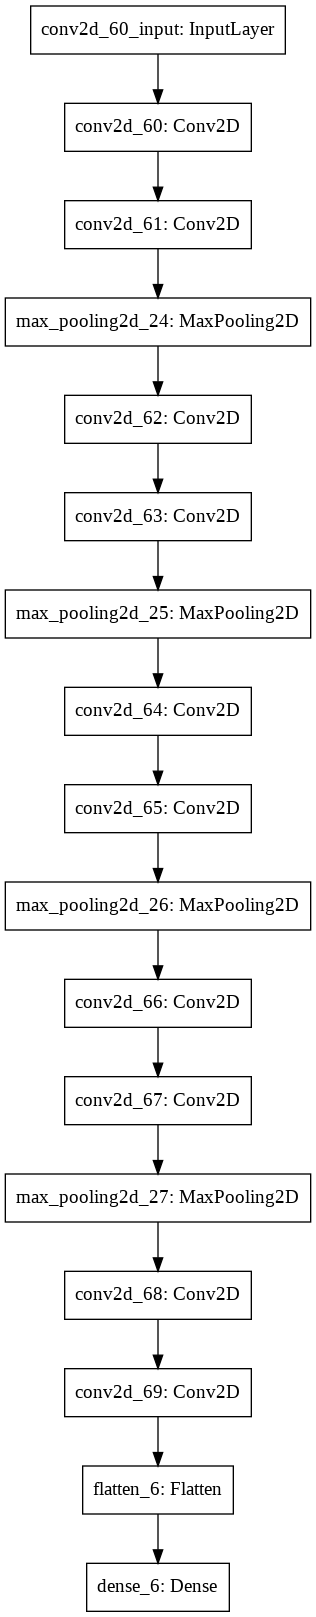

In [49]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

---

### **Answer:**

### This model achieved a high validation accuracy score of 95.5%. It did so by having the same filter size (3x3) throughout the whole network, and by using two convolutional layers back-to-back having the same number of filters, two times in a row (i.e., 32 filters for the first 4 convolutional layers - split between max pooling, then after max pooling, 64 filters four times, split between max pooling again. 

### I believe this gradual increase in the number of filters (before tapering this number down at the end) helped increase the model's validation accuracy. Padding remained the same throughout the entire network, which also helped increase validation accuracy. I used ReduceLROnPlateu, but in this particular case I don't think it helped much since accuracy spiked early on in the number of epochs. However, model check point definitely helped, as it did with all of my good accuracy models. 

---
---

# **Model 2: Version of SqueezeNet**

---


In [135]:
# Let's build a squeezenet model instead to see how well it performs 
# Does adding more layers help (i.e.- try building a deeper and deeper network)
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
l = tf.keras.layers # syntax shortcut

# Create function to define fire modules
def fire(x, squeeze, expand):
  y = l.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x) 
  y1 = l.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y) # note: //2 takes input value and divides by 2, so we reach the dimensions requested with stacking later.
  y3 = l.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  return tf.keras.layers.concatenate([y1, y3])

# this is to make it behave similarly to other Keras layers
def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)


with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
            x = tf.keras.layers.Input(shape=[192,192, 3]) # input is 192x192 pixels RGB

            y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
            y = fire_module(8, 16)(y)
            y = tf.keras.layers.BatchNormalization()(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = fire_module(16, 32)(y)
            y = tf.keras.layers.BatchNormalization()(y)
            y = fire_module(26, 32)(y)
            y = tf.keras.layers.BatchNormalization()(y)
            y = fire_module(32, 64)(y)
            y = tf.keras.layers.BatchNormalization()(y)                         
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = fire_module(32, 64)(y)
            y = tf.keras.layers.BatchNormalization()(y)
            y = fire_module(64, 128)(y)
            y = tf.keras.layers.BatchNormalization()(y)
            y = fire_module(64, 128)(y)
            y = tf.keras.layers.BatchNormalization()(y)
            y = fire_module(128, 256)(y)
            y = tf.keras.layers.BatchNormalization()(y)                        
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = fire_module(128, 256)(y)
            y = tf.keras.layers.BatchNormalization()(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu')(y)
            y = tf.keras.layers.BatchNormalization()(y)                       
            y = tf.keras.layers.GlobalAveragePooling2D()(y) # Takes average of h x w for each channel and returns 1 scalar value per channel
            y = tf.keras.layers.Dense(3, activation='softmax')(y) # Parameters for final layer from GAP = number of channels in previous layer plus number of dense nodes in output layer times number of dense nodes

            model = tf.keras.Model(x, y)

            red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.05) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs
            mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True)
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
        
            model.fit(X_train, y_train, 
                    epochs = 25, verbose=1,validation_split=0.20,batch_size=32,callbacks=[red_lr, mc])

Train on 2486 samples, validate on 622 samples
Epoch 1/25
2464/2486 [============================>.] - ETA: 0s - loss: 0.3843 - acc: 0.8632
Epoch 00001: val_acc improved from -inf to 0.28939, saving model to best_model.h5
2486/2486 [==============================] - 164s 66ms/sample - loss: 0.3827 - acc: 0.8640 - val_loss: 3.9225 - val_acc: 0.2894
Epoch 2/25
2464/2486 [============================>.] - ETA: 0s - loss: 0.2143 - acc: 0.9286
Epoch 00002: val_acc did not improve from 0.28939
2486/2486 [==============================] - 28s 11ms/sample - loss: 0.2136 - acc: 0.9288 - val_loss: 5.0210 - val_acc: 0.2894
Epoch 3/25
2464/2486 [============================>.] - ETA: 0s - loss: 0.1681 - acc: 0.9420
Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.

Epoch 00003: val_acc did not improve from 0.28939
2486/2486 [==============================] - 35s 14ms/sample - loss: 0.1681 - acc: 0.9421 - val_loss: 5.6499 - val_acc: 0.2717
Epoch 4/25
2464/2486 [======

In [136]:
import tensorflow.keras.backend as K

print(model.get_config()) # Full configuration to fit keras model
print(K.eval(model.optimizer.get_config())) # Optimizer configuration
print(len(model.history.epoch)) # Number of epochs

{'name': 'model_23', 'layers': [{'name': 'input_8', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 192, 192, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_8'}, 'inbound_nodes': []}, {'name': 'conv2d_624', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_624', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'inbound_nodes': [[['input_8', 0, 0, {}]]]}, {'name': 'conv2d_625', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_625', 'trainable': True, 'dtype': 'float32', 

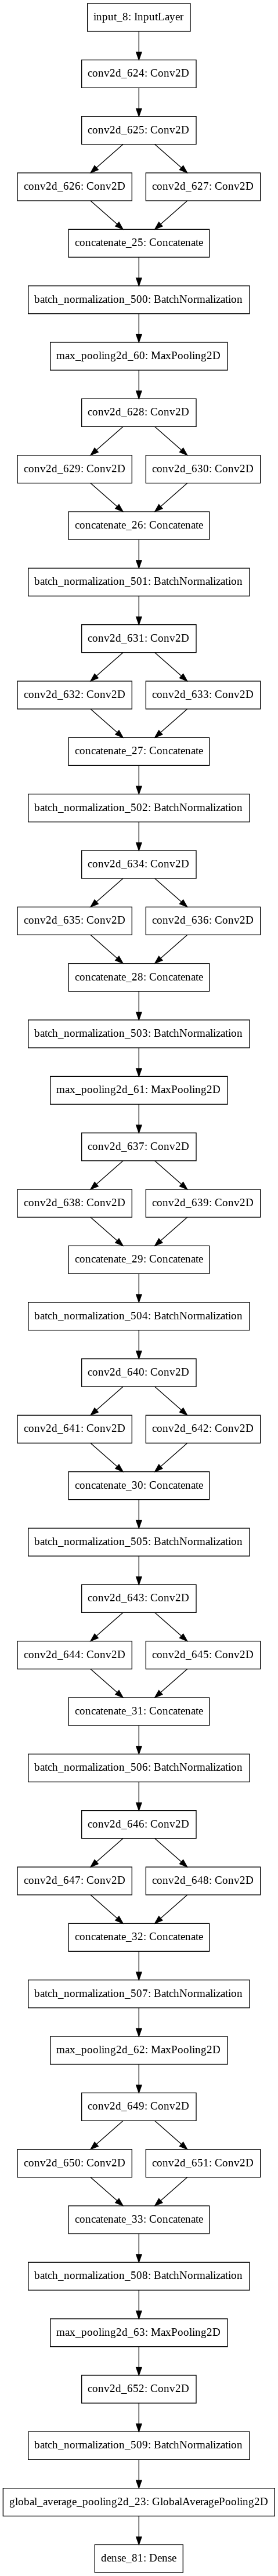

In [137]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

---

### **Answer:**

### This squeezenet-like model above yielded a validation accuracy score of 97.3%. This was, therefore, my best model. Though I submitted it to the leader board, for some reason the leader board (version 62) says my model achieved an accuracy score of 0.94, which is incorrect, and it lists it as a sequential model, which is also not correct. The non-shared model_eval_metrics also for some reason says my model achieved an accuracy  score of 0.96, which is also incorrect. I never had any models with these validation accuracy scores. 

### This best model's accuracy, I believe, was enhanced by adding so many layers, a large number of fire modules (standard 1x1 and 3x3 filters) with concatonation throughout the network (8 times), and by adding Batch Normalization before and after most convolutional layers - though I did not place Batch Normalization inside the fire modules. The model uses the functional API instead of sequential, in order to allow for concatonation. I gradually expanded the convolutional layer filter sizes themselves (though not the fire module filter sizes), starting with 8x8, and reaching 128x128. I believe the use of fire modules and concatonation (expanding and contracting the channels) also increased validation accuracy.
---
---


### **Model 3: Version of InceptionV3**

In [120]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_530 (Conv2D)             (None, 95, 95, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_406 (BatchN (None, 95, 95, 32)   96          conv2d_530[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 95, 95, 32)   0           batch_normalization_406[0][0]    
_______________________________________________________________________________________

In [121]:
len(base_model.trainable_variables)

188

In [122]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune everything up to this layer onwards
freeze_layers_after=9

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model.layers[freeze_layers_after:]:
  layer.trainable =  False

print("Number of layers frozen in the base model: ", len(base_model.layers)-freeze_layers_after)

#base_model.trainable = False
#base_model.summary() 

Number of layers in the base model:  311
Number of layers frozen in the base model:  302


In [123]:
len(base_model.trainable_variables) #trainable layers after freezing

6

In [130]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K



# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
class1 = Dense(256, activation='relu')(gap1)
class1 = Dense(256, activation='relu')(class1)
output = Dense(3, activation='softmax')(class1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)



# summarize
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_530 (Conv2D)             (None, 95, 95, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_406 (BatchN (None, 95, 95, 32)   96          conv2d_530[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 95, 95, 32)   0           batch_normalization_406[0][0]    
___________________________________________________________________________________________

In [132]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=1,verbose=1,factor=0.35)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train, batch_size=25,
          epochs = 10, verbose=1, validation_split=0.20, callbacks=[mc,red_lr])  

Train on 2486 samples, validate on 622 samples
Epoch 1/10
2475/2486 [============================>.] - ETA: 0s - loss: 0.2924 - acc: 0.8881
Epoch 00001: val_acc improved from -inf to 0.68810, saving model to best_model.h5
2486/2486 [==============================] - 69s 28ms/sample - loss: 0.2912 - acc: 0.8886 - val_loss: 1.1358 - val_acc: 0.6881
Epoch 2/10
2475/2486 [============================>.] - ETA: 0s - loss: 0.2437 - acc: 0.9115
Epoch 00002: val_acc did not improve from 0.68810

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00035000001662410796.
2486/2486 [==============================] - 40s 16ms/sample - loss: 0.2472 - acc: 0.9103 - val_loss: 2.2877 - val_acc: 0.6350
Epoch 3/10
2475/2486 [============================>.] - ETA: 0s - loss: 0.1690 - acc: 0.9398
Epoch 00003: val_acc did not improve from 0.68810

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00012250000581843777.
2486/2486 [==============================] - 33s 13ms/sample - loss: 0.168

In [133]:
import tensorflow.keras.backend as K

print(model.get_config()) # Full configuration to fit keras model
print(K.eval(model.optimizer.get_config())) # Optimizer configuration
print(len(model.history.epoch)) # Number of epochs

{'name': 'model_22', 'layers': [{'name': 'input_7', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 192, 192, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_7'}, 'inbound_nodes': []}, {'name': 'conv2d_530', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_530', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (2, 2), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'inbound_nodes': [[['input_7', 0, 0, {}]]]}, {'name': 'batch_normalization_406', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_406

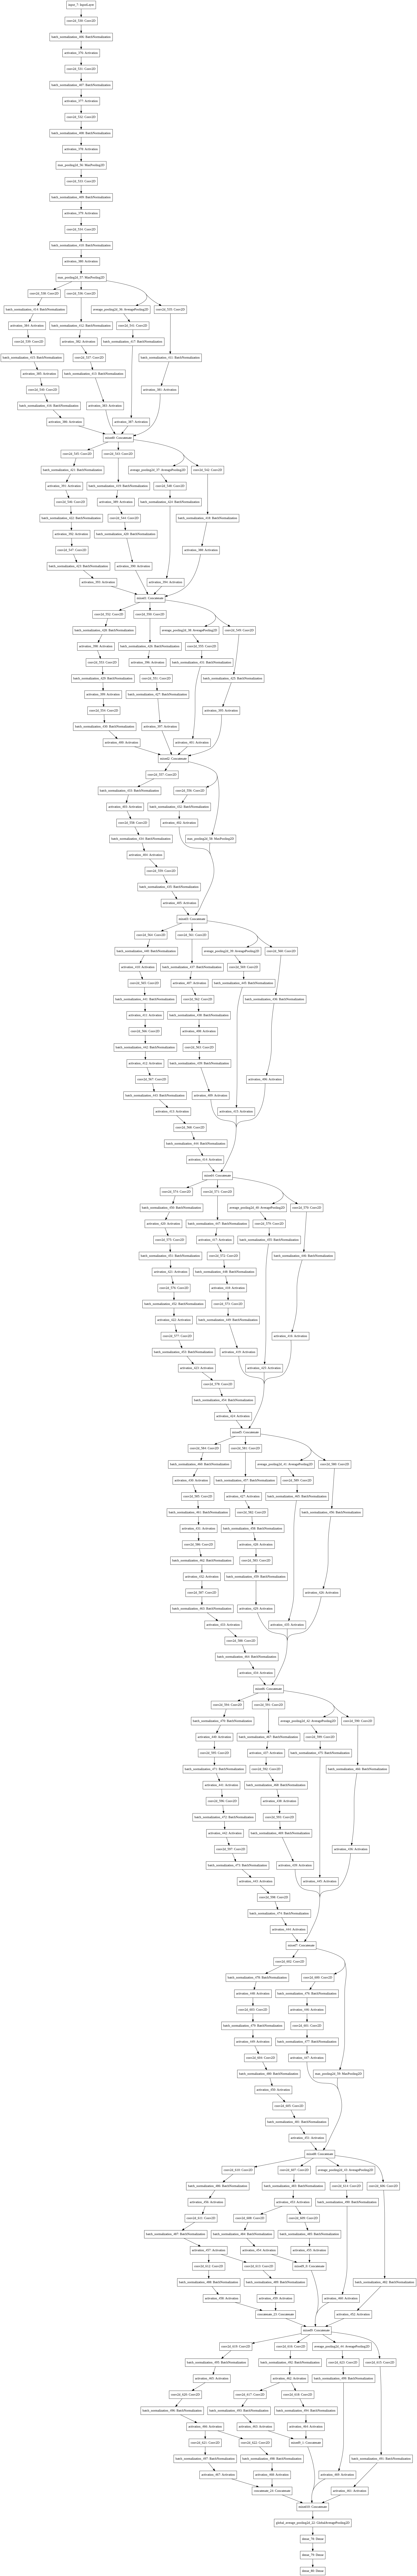

In [134]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

---
---

### **Answer:** 

**I was, unfortunately, disappointed with the results from my InceptionV3 transfer learning model. It achieved a validation accuracy rate of 68.8%. What is strange is that I used essentially the same parameters for this model initially, and obtained an accuracy rating of 99%. Then, because Colab's GPU disconnected me, I had to re-run the model, and I ended up getting a percentage somewhere in the 30% range. After a while, I finally managed to increase the accuracy to 68.8%.**  

**I set freeze_layers_after = 9. This meant that whilee the total number of layers in the base model was originally 311, the number of frozen layers was 302. Like all transfer learning models, InceptionV3 relies on a functional API design.** 

**I set up the model first with the base model input, followed by Global Average Pooling. This was followed by 2 dense layers of 256 hidden neurons each, and an output layer of 3 classes, 1 for X-rays of individuals with pneumonia, individuals who have no illness, and individuals with COVID-19. The total number of trainable parameters was 619,747. I used a batch size of 25, and a ReduceOnPlateu with a patience value = 1 (and combined it with a factor of 0.35), since patience values of 2 and 3 seemed to be leading the validation accuracy to get stuck at small values. The relatively higher factor, when combined with patience = 1 did end up increasing the validation accuracy of the model.**

---
---


### **Professor Parrott said that due to technical difficulties we are not required to take the model from the leader on the leader board, to visualize and analyze it. For this reason, I have not added this section.**

In [138]:
# test with aimodelshare library
! pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

Looking in indexes: https://pypi.org/simple, https://test.pypi.org/simple/
     |████████████████████████████████| 61kB 1.9MB/s 
     |████████████████████████████████| 9.0MB 345kB/s 
     |████████████████████████████████| 133kB 5.8MB/s 
     |████████████████████████████████| 102kB 8.8MB/s 
     |████████████████████████████████| 235kB 30.9MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 4.1MB 39.8MB/s 
     |████████████████████████████████| 133kB 40.4MB/s 
     |████████████████████████████████| 256kB 38.1MB/s 
     |████████████████████████████████| 7.3MB 38.5MB/s 
     |████████████████████████████████| 81kB 6.4MB/s 
     |████████████████████████████████| 92kB 10.0MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=bfeec6cfd37893576455ab209b22a1254ecfc4911c4faf9c33a39569705f45a4
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
Succe

In [139]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

[2 1 0 1 2 0 1 0 1 2 1 1 0 2 0 2 0 1 1 2 2 2 1 0 2 2 2 1 1 2 1 0 1 1 2 0 2
 1 0 2 0 0 2 0 1 1 0 0 2 1 2 0 2 1 1 1 1 0 1 2 2 0 0 1 1 1 2 1 2 1 1 2 0 0
 1 1 1 2 0 1 0 1 2 1 0 2 1 2 0 1 1 1 2 2 0 2 0 1 1 0 1 0 0 1 2 1 0 1 0 0 0
 0 0 2 2 2 2 2 1 2 1 2 1 1 0 2 0 2 0 1 1 2 1 0 0 0 2 0 1 0 0 1 1 2 1 0 0 0
 1 1 2 1 1 1 2 1 0 0 2 1 2 0 0 0 2 2 1 0 0 0 2 1 2 2 0 0 0 2 0 2 2 2 1 1 2
 2 0 2 1 1 2 1 0 2 2 1 2 1 2 2 0 2 0 1 0 0 0 2 1 1 1 2 0 0 1 1 1 1 2 2 2 0
 2 2 2 0 2 1 2 1 1 2 0 1 1 1 1 1 0 2 1 1 0 2 2 0 2 0 1 1 0 2 1 0 2 2 0 0 2
 0 1 0 1 2 2 1 2 1 1 1 0 2 0 2 2 2 1 2 2 1 1 0 2 2 0 0 0 1 0 2 1 2 0 2 2 2
 2 0 1 0 0 1 2 2 1 2 0 0 1 2 0 1 2 2 1 0 1 2 0 2 1 2 1 0 2 1 2 2 1 1 0 1 0
 1 0 2 2 1 0 2 2 0 0 2 0 2 0 2 1 2 0 1 2 0 1 0 2 2 1 0 0 0 1 0 1 0 0 2 1 0
 0 2 0 2 1 2 2 1 2 0 2 1 1 2 0 1 1 2 0 2 2 0 2 1 1 2 2 0 0 1 2 2 0 1 0 0 2
 2 2 2 0 1 1 2 0 2 2 0 1 0 0 0 0 1 2 2 1 1 1 1 0 2 1 1 2 1 2 0 2 2 0 2 2 2
 2 0 0 0 0 2 2 1 2 2 2 2 1 2 1 2 1 1 2 2 1 2 2 2 0 1 0 2 0 1 2 0 1 0 2 2 2
 1 1 1 1 1 0 1 0 2 1 0 2 

In [140]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels


In [141]:
# get metrics
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.96144,0.962396,0.962207,0.962676,0,0,0,0


###COVID Hackathon Code for Submitting:

In [ ]:
# test with aimodelshare library
! pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

In [ ]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

[2 1 0 1 2 0 1 0 1 2 1 1 0 2 0 2 0 1 1 2 2 2 1 0 2 1 2 1 1 2 1 0 1 1 2 0 2
 1 0 0 0 0 2 0 1 1 0 0 2 1 2 0 2 1 1 1 1 0 1 2 1 0 0 1 1 1 2 1 2 1 1 2 0 2
 1 1 1 1 0 1 0 1 2 1 0 2 1 2 0 1 1 1 2 2 0 2 0 1 2 0 1 0 0 1 1 1 0 2 0 0 0
 0 0 2 2 2 2 2 1 2 1 2 1 1 0 2 0 2 0 1 1 2 1 0 0 0 2 0 1 0 0 1 1 2 1 0 0 0
 1 1 2 1 1 1 2 0 0 0 2 1 2 0 0 0 2 2 1 2 0 0 1 1 1 0 0 0 0 2 0 2 2 1 1 1 2
 1 0 2 1 1 2 1 0 2 1 1 2 1 2 2 0 1 0 1 0 2 0 2 1 1 1 2 0 0 1 1 1 1 2 2 2 0
 2 2 2 0 2 1 2 1 1 2 0 1 1 1 1 1 0 2 1 2 0 2 1 0 2 0 1 1 0 2 1 0 2 2 2 0 1
 0 1 0 1 2 2 1 2 0 1 1 0 2 0 2 2 2 1 2 2 1 1 0 1 2 0 0 0 1 0 2 2 1 0 2 1 2
 0 0 1 0 0 1 2 2 1 2 0 0 1 2 0 1 2 2 1 0 1 2 0 2 1 2 1 0 2 1 2 2 1 1 0 1 0
 1 0 0 2 1 0 1 2 0 0 2 0 2 0 2 1 2 0 1 2 0 1 0 2 2 1 0 0 0 1 0 1 0 0 2 1 0
 1 2 0 0 1 2 2 1 2 0 2 1 1 0 0 1 1 2 0 0 2 0 2 2 1 1 2 0 0 1 2 2 0 1 0 0 2
 2 2 2 0 1 1 2 0 2 2 0 1 2 0 0 0 1 2 2 1 1 1 1 0 2 1 2 2 1 2 0 2 2 0 2 2 2
 0 0 0 0 1 2 1 1 2 2 2 2 1 2 1 2 1 1 2 2 1 1 0 2 0 1 0 2 0 1 2 0 2 0 1 2 2
 1 1 1 1 1 0 1 0 2 1 0 2 

In [ ]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels


In [ ]:
# get metrics
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.94473,0.944723,0.944812,0.945219,0,0,0,0


In [142]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") #ignore error "can't pickle module objects"

In [143]:
from aimodelshare.aimsonnx import model_to_onnx
# transform sklearn model to ONNX
onnx_model_keras= model_to_onnx(model, framework='keras', 
                                   transfer_learning=False,
                                   deep_learning=True,
                                   task_type='classification')

# Save model to local .onnx file
with open("onnx_model_keras.onnx", "wb") as f:
    f.write(onnx_model_keras.SerializeToString())

The ONNX operator number change on the optimization: 183 -> 88


In [144]:
# Set credentials to submit new model/preprocessor

from aimodelshare.aws import set_credentials
set_credentials(credential_file="credentials.txt", type="submit_model", apiurl="https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m") #Covid image prediction apiURL

AI Model Share login credentials set successfully.
AWS credentials set successfully.


In [145]:
import aimodelshare as ai
import os
token=ai.aws.get_aws_token(os.environ.get("username"), os.environ.get("password"))
awscreds=ai.aws.get_aws_client(aws_key=os.environ.get('AWS_ACCESS_KEY_ID'), aws_secret=os.environ.get('AWS_SECRET_ACCESS_KEY'), aws_region=os.environ.get('AWS_REGION'))

In [146]:
# Submit_model() to leaderboard
ai.submit_model("onnx_model_keras.onnx",
                "https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predicted_labels,
                preprocessor="preprocessor.zip")

'Your model has been submitted as model version 63'

In [147]:
import pandas
data=ai.get_leaderboard("https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,verbose=1)

#get rid of any duplicate model submissions
#data=data.loc[data.iloc[:,0:8].duplicated()==False,:]
data.fillna(0,inplace=True)
data

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,loss,optimizer,model_config,username,timestamp,version
0,0.992288,0.992486,0.992412,0.992565,keras,True,True,Model,26,39162947,str,Adam,"{'name': 'model_11', 'layers': [{'name': 'inpu...",dv2438,2021-03-07 23:02:41.978914,45
1,0.985861,0.986088,0.986470,0.985770,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': [{'name': 'input...",kagenlim,2021-03-04 02:50:38.718996,8
2,0.985861,0.986088,0.986470,0.985770,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': [{'name': 'input...",kagenlim,2021-03-04 02:49:57.183806,7
3,0.983290,0.983636,0.983446,0.983891,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-08 00:43:34.857578,48
4,0.980720,0.981091,0.981226,0.981263,keras,False,True,Model,26,39162947,str,Adam,"{'name': 'model_12', 'layers': [{'name': 'inpu...",dv2438,2021-03-06 16:06:55.748014,26
5,0.979434,0.979710,0.979604,0.980173,keras,True,True,Model,313,21808931,str,Adam,"{'name': 'model_4', 'layers': [{'name': 'input...",prajseth,2021-03-08 02:34:38.630185,50
6,0.978149,0.978550,0.978470,0.978635,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-08 00:50:31.207727,49
7,0.975578,0.976024,0.975700,0.976456,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-07 08:55:54.375970,40
8,0.975578,0.976001,0.975782,0.976456,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-08 00:39:11.372915,47
9,0.970437,0.971197,0.971771,0.970751,keras,False,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': [{'name': 'input...",mro9395,2021-03-05 20:15:43.157299,18


In [ ]:
ai.stylize_leaderboard(data,category="classification")

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,loss,optimizer,model_config,username,version
0,95.89%,95.93%,96.01%,95.87%,keras,True,True,Sequential,16,41083,str,Adam,"{'name': 'sequential', 'layers...",mikedparrott,2
1,94.47%,94.47%,94.48%,94.52%,keras,False,True,Sequential,16,41083,str,Adam,"{'name': 'sequential', 'layers...",newusertest,3
